In [97]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import random

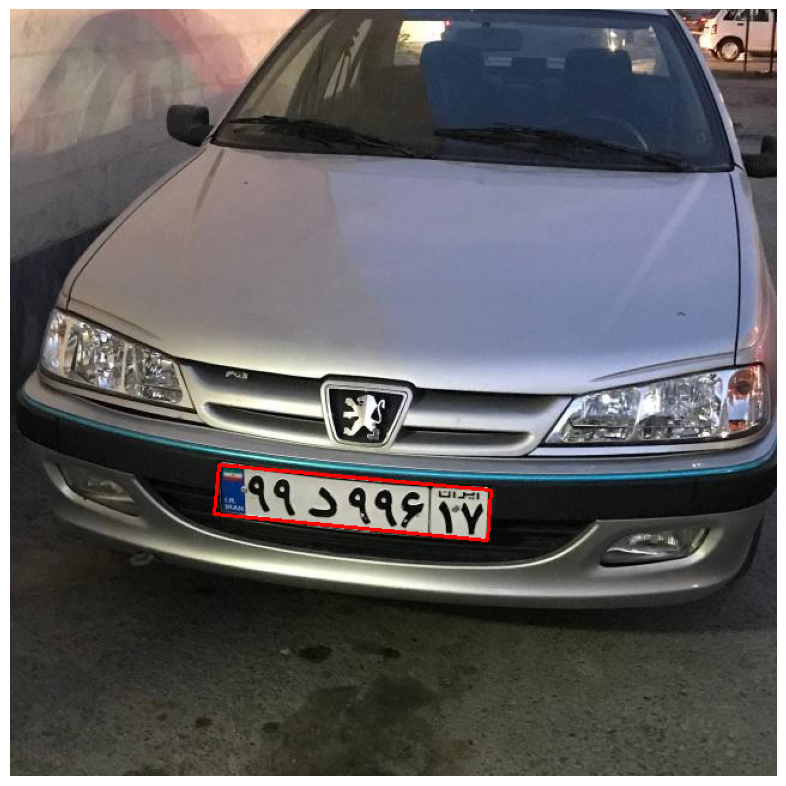

In [59]:
def visualize_image_with_bbox(image_path, label_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    img_h, img_w, _ = image.shape

    # Читаем разметку
    with open(label_path, 'r') as file:
        lines = file.readlines()
    
    # Рисуем bounding boxes
    for line in lines:
        parts = list(map(float, line.split()))
        class_id = int(parts[0])  
        points = parts[1:] 

        x1, y1 = int(points[0] * img_w), int(points[1] * img_h)
        x2, y2 = int(points[2] * img_w), int(points[3] * img_h)
        x3, y3 = int(points[4] * img_w), int(points[5] * img_h)
        x4, y4 = int(points[6] * img_w), int(points[7] * img_h)

        pts = [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1, 1, 2))
        
        cv2.polylines(image, [pts], isClosed=True, color=(255, 0, 0), thickness=2)

    # Визуализация изображения с bbox
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')

    # Принудительная очистка графика и отображение
    plt.tight_layout()
    plt.show(block=False)
    plt.pause(1)  # Пауза для отображения изображения
    plt.close()

# Путь к данным
data_dir = 'data/train'  
images_dir = os.path.join(data_dir, 'images')
labels_dir = os.path.join(data_dir, 'labels')

# Загрузка файлов
image_files = os.listdir(images_dir)
label_files = os.listdir(labels_dir)

# Убираем расширения
image_basenames = [os.path.splitext(f)[0] for f in image_files]
label_basenames = [os.path.splitext(f)[0] for f in label_files]

# Визуализация первого изображения с разметкой
for image_file, image_base in zip(image_files, image_basenames):
    if image_base in label_basenames:
        image_path = os.path.join(images_dir, image_file)
        label_path = os.path.join(labels_dir, image_base + '.txt')
        
        visualize_image_with_bbox(image_path, label_path)
        break
    else:
        print(f"Файл разметки для {image_file} не найден.")

In [61]:
class SimpleAugmentation:
    def __init__(self, brightness_delta=0.2, contrast_limit=(0.8, 1.2)):
        self.brightness_delta = brightness_delta
        self.contrast_limit = contrast_limit

    def __call__(self, image):
        if np.random.rand() > 0.5:
            image = cv2.convertScaleAbs(image, alpha=1, beta=np.random.uniform(-self.brightness_delta, self.brightness_delta))
        
        if np.random.rand() > 0.5:
            contrast_factor = np.random.uniform(self.contrast_limit[0], self.contrast_limit[1])
            image = cv2.convertScaleAbs(image, alpha=contrast_factor, beta=0)

        return image

In [63]:
class ComplexAugmentation:
    def __init__(self, rotate_limit=15, shift_limit=10):
        self.rotate_limit = rotate_limit
        self.shift_limit = shift_limit

    def rotate_image(self, image, angle):
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h))
        return rotated

    def shift_image(self, image, shift_x, shift_y):
        M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
        shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
        return shifted

    def __call__(self, image, boxes):
        angle = np.random.uniform(-self.rotate_limit, self.rotate_limit)
        image = self.rotate_image(image, angle)

        shift_x = np.random.uniform(-self.shift_limit, self.shift_limit)
        shift_y = np.random.uniform(-self.shift_limit, self.shift_limit)
        image = self.shift_image(image, shift_x, shift_y)

        return image, boxes

In [65]:
class LicensePlateDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_files = os.listdir(images_dir)
        self.label_files = os.listdir(labels_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)
        label_path = os.path.join(self.labels_dir, os.path.splitext(image_name)[0] + '.txt')

        # Чтение изображения
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Преобразуем изображение в тензор
        if self.transform:
            image = self.transform(image)

        # Чтение меток и преобразование четырехугольников в bounding boxes
        with open(label_path, 'r') as f:
            boxes = []
            for line in f.readlines():
                parts = list(map(float, line.split()))
                coords = parts[1:]  # Пропускаем class_id и берем только координаты углов
                
                # Координаты углов
                x1, y1 = coords[0], coords[1]
                x2, y2 = coords[2], coords[3]
                x3, y3 = coords[4], coords[5]
                x4, y4 = coords[6], coords[7]

                # Находим минимальные и максимальные координаты
                min_x = min(x1, x2, x3, x4)
                max_x = max(x1, x2, x3, x4)
                min_y = min(y1, y2, y3, y4)
                max_y = max(y1, y2, y3, y4)

                # Вычисляем центр и размеры bounding box
                x_center = (min_x + max_x) / 2
                y_center = (min_y + max_y) / 2
                width = max_x - min_x
                height = max_y - min_y

                # Добавляем bounding box в формат (x_center, y_center, width, height)
                boxes.append([x_center, y_center, width, height])

        boxes = torch.tensor(boxes, dtype=torch.float32)

        return image, boxes


In [67]:
# Директории данных
train_images_dir = 'data/train/images'
train_labels_dir = 'data/train/labels'

# Преобразования изображений
transform = transforms.ToTensor()

# Создаем датасет
train_dataset = LicensePlateDataset(train_images_dir, train_labels_dir, transform=transform)

# Создаем DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


In [69]:
for images, labels in train_loader:
    print(images.shape)  # Проверяем форму батча изображений
    print(labels)  # Проверяем метки
    break  # Для теста загружаем только один батч


torch.Size([4, 3, 640, 640])
tensor([[[0.47642, 0.51533, 0.38585, 0.13679]],

        [[0.69578, 0.59662, 0.21996, 0.12518]],

        [[0.52374, 0.73752, 0.25140, 0.05689]],

        [[0.50260, 0.59695, 0.41607, 0.08515]]])


In [71]:
def train_model(model, train_loader, optimizer, device, epochs):
    model.train() 

    for epoch in range(epochs):
        running_loss = 0.0

        loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

        for images, labels in loop:

            images = images.to(device)

            labels = [{ 'boxes': label } for label in labels]

            optimizer.zero_grad()

            optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {1}')

    print('Обучение завершено!')

In [119]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Переходим в режим обучения
model.train()

# Параметры обучения
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Гиперпараметры
epochs = 100
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

Using cache found in C:\Users\baben_bakg1j1/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-10-16 Python-3.12.4 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [121]:
train_model(model, train_loader, optimizer, device, epochs)

Epoch 1/100: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 18.64it/s]


Epoch [1/100], Loss: 1


Epoch 2/100: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 19.97it/s]


Epoch [2/100], Loss: 1


Epoch 3/100: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.03it/s]


Epoch [3/100], Loss: 1


Epoch 4/100: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 19.50it/s]


Epoch [4/100], Loss: 1


Epoch 5/100: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.67it/s]


Epoch [5/100], Loss: 1


Epoch 6/100: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.43it/s]


Epoch [6/100], Loss: 1


Epoch 7/100: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.52it/s]


Epoch [7/100], Loss: 1


Epoch 8/100: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.39it/s]


Epoch [8/100], Loss: 1


Epoch 9/100: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.81it/s]


Epoch [9/100], Loss: 1


Epoch 10/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.59it/s]


Epoch [10/100], Loss: 1


Epoch 11/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.74it/s]


Epoch [11/100], Loss: 1


Epoch 12/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.22it/s]


Epoch [12/100], Loss: 1


Epoch 13/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.17it/s]


Epoch [13/100], Loss: 1


Epoch 14/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.91it/s]


Epoch [14/100], Loss: 1


Epoch 15/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.42it/s]


Epoch [15/100], Loss: 1


Epoch 16/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.43it/s]


Epoch [16/100], Loss: 1


Epoch 17/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.49it/s]


Epoch [17/100], Loss: 1


Epoch 18/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.22it/s]


Epoch [18/100], Loss: 1


Epoch 19/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.35it/s]


Epoch [19/100], Loss: 1


Epoch 20/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.02it/s]


Epoch [20/100], Loss: 1


Epoch 21/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.15it/s]


Epoch [21/100], Loss: 1


Epoch 22/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.50it/s]


Epoch [22/100], Loss: 1


Epoch 23/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.53it/s]


Epoch [23/100], Loss: 1


Epoch 24/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.70it/s]


Epoch [24/100], Loss: 1


Epoch 25/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.46it/s]


Epoch [25/100], Loss: 1


Epoch 26/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.19it/s]


Epoch [26/100], Loss: 1


Epoch 27/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.20it/s]


Epoch [27/100], Loss: 1


Epoch 28/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.01it/s]


Epoch [28/100], Loss: 1


Epoch 29/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.72it/s]


Epoch [29/100], Loss: 1


Epoch 30/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.98it/s]


Epoch [30/100], Loss: 1


Epoch 31/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.83it/s]


Epoch [31/100], Loss: 1


Epoch 32/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.63it/s]


Epoch [32/100], Loss: 1


Epoch 33/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.20it/s]


Epoch [33/100], Loss: 1


Epoch 34/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.80it/s]


Epoch [34/100], Loss: 1


Epoch 35/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.49it/s]


Epoch [35/100], Loss: 1


Epoch 36/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.72it/s]


Epoch [36/100], Loss: 1


Epoch 37/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 18.67it/s]


Epoch [37/100], Loss: 1


Epoch 38/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.25it/s]


Epoch [38/100], Loss: 1


Epoch 39/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.45it/s]


Epoch [39/100], Loss: 1


Epoch 40/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.22it/s]


Epoch [40/100], Loss: 1


Epoch 41/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.17it/s]


Epoch [41/100], Loss: 1


Epoch 42/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.12it/s]


Epoch [42/100], Loss: 1


Epoch 43/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 18.85it/s]


Epoch [43/100], Loss: 1


Epoch 44/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.30it/s]


Epoch [44/100], Loss: 1


Epoch 45/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.60it/s]


Epoch [45/100], Loss: 1


Epoch 46/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.30it/s]


Epoch [46/100], Loss: 1


Epoch 47/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.84it/s]


Epoch [47/100], Loss: 1


Epoch 48/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.88it/s]


Epoch [48/100], Loss: 1


Epoch 49/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.93it/s]


Epoch [49/100], Loss: 1


Epoch 50/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.04it/s]


Epoch [50/100], Loss: 1


Epoch 51/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.10it/s]


Epoch [51/100], Loss: 1


Epoch 52/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.52it/s]


Epoch [52/100], Loss: 1


Epoch 53/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.37it/s]


Epoch [53/100], Loss: 1


Epoch 54/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.88it/s]


Epoch [54/100], Loss: 1


Epoch 55/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.72it/s]


Epoch [55/100], Loss: 1


Epoch 56/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.17it/s]


Epoch [56/100], Loss: 1


Epoch 57/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.79it/s]


Epoch [57/100], Loss: 1


Epoch 58/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.24it/s]


Epoch [58/100], Loss: 1


Epoch 59/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.10it/s]


Epoch [59/100], Loss: 1


Epoch 60/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.29it/s]


Epoch [60/100], Loss: 1


Epoch 61/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.84it/s]


Epoch [61/100], Loss: 1


Epoch 62/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.79it/s]


Epoch [62/100], Loss: 1


Epoch 63/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.94it/s]


Epoch [63/100], Loss: 1


Epoch 64/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.20it/s]


Epoch [64/100], Loss: 1


Epoch 65/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.09it/s]


Epoch [65/100], Loss: 1


Epoch 66/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.21it/s]


Epoch [66/100], Loss: 1


Epoch 67/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.20it/s]


Epoch [67/100], Loss: 1


Epoch 68/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.05it/s]


Epoch [68/100], Loss: 1


Epoch 69/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.64it/s]


Epoch [69/100], Loss: 1


Epoch 70/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.01it/s]


Epoch [70/100], Loss: 1


Epoch 71/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 19.85it/s]


Epoch [71/100], Loss: 1


Epoch 72/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.78it/s]


Epoch [72/100], Loss: 1


Epoch 73/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 19.86it/s]


Epoch [73/100], Loss: 1


Epoch 74/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 18.97it/s]


Epoch [74/100], Loss: 1


Epoch 75/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.53it/s]


Epoch [75/100], Loss: 1


Epoch 76/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.43it/s]


Epoch [76/100], Loss: 1


Epoch 77/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.79it/s]


Epoch [77/100], Loss: 1


Epoch 78/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.50it/s]


Epoch [78/100], Loss: 1


Epoch 79/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.72it/s]


Epoch [79/100], Loss: 1


Epoch 80/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.74it/s]


Epoch [80/100], Loss: 1


Epoch 81/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.43it/s]


Epoch [81/100], Loss: 1


Epoch 82/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.52it/s]


Epoch [82/100], Loss: 1


Epoch 83/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.47it/s]


Epoch [83/100], Loss: 1


Epoch 84/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.61it/s]


Epoch [84/100], Loss: 1


Epoch 85/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.64it/s]


Epoch [85/100], Loss: 1


Epoch 86/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.50it/s]


Epoch [86/100], Loss: 1


Epoch 87/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.61it/s]


Epoch [87/100], Loss: 1


Epoch 88/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.59it/s]


Epoch [88/100], Loss: 1


Epoch 89/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.46it/s]


Epoch [89/100], Loss: 1


Epoch 90/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.66it/s]


Epoch [90/100], Loss: 1


Epoch 91/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.01it/s]


Epoch [91/100], Loss: 1


Epoch 92/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.67it/s]


Epoch [92/100], Loss: 1


Epoch 93/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.74it/s]


Epoch [93/100], Loss: 1


Epoch 94/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.44it/s]


Epoch [94/100], Loss: 1


Epoch 95/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.76it/s]


Epoch [95/100], Loss: 1


Epoch 96/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.87it/s]


Epoch [96/100], Loss: 1


Epoch 97/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.61it/s]


Epoch [97/100], Loss: 1


Epoch 98/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.54it/s]


Epoch [98/100], Loss: 1


Epoch 99/100: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.65it/s]


Epoch [99/100], Loss: 1


Epoch 100/100: 100%|███████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.62it/s]


Epoch [100/100], Loss: 1
Обучение завершено!


C:\Users\baben_bakg1j1/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Best box: [   -0.31801     -1.3757    -0.22117     0.28354], Score: -3.0543053150177


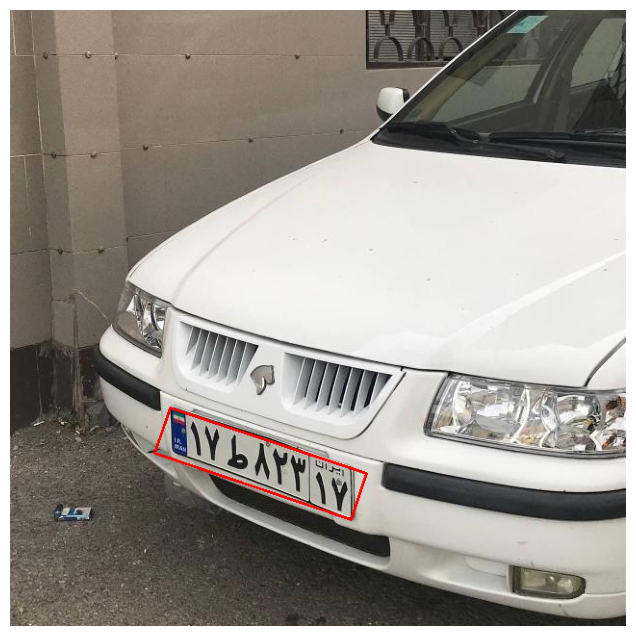

C:\Users\baben_bakg1j1/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Best box: [    0.86597    -0.19119      1.6691    -0.29261], Score: 1.588087558746338


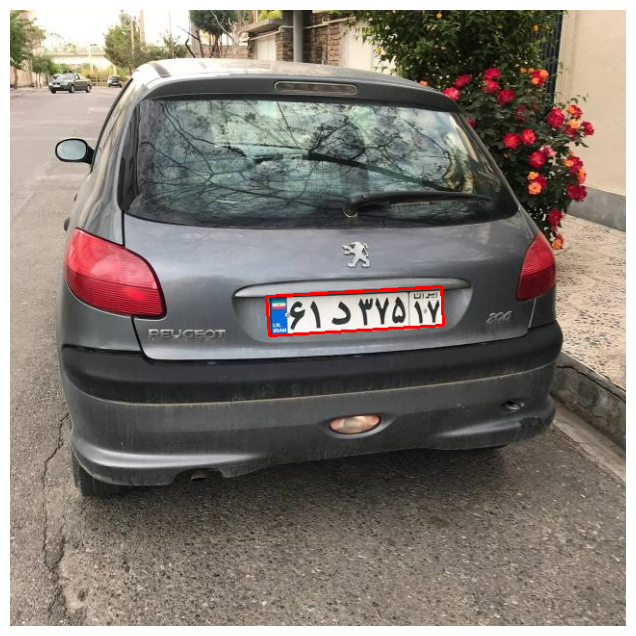

C:\Users\baben_bakg1j1/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Best box: [    0.29722    -0.35886      1.4559      1.9036], Score: -2.1648194789886475


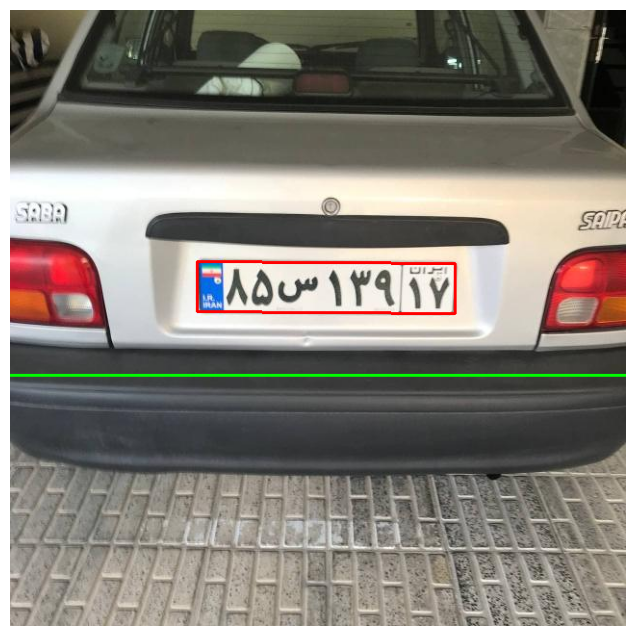

In [137]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_image_with_bbox_and_predictions(image_path, label_path, model, device):
    # Загружаем изображение
    image = cv2.imread(image_path)
    if image is None:
        print(f"Не удалось загрузить изображение: {image_path}")
        return
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w, _ = image.shape

    # Читаем разметку из файла
    with open(label_path, 'r') as file:
        lines = file.readlines()
    
    # Отображаем истинные рамки из файла
    for line in lines:
        parts = list(map(float, line.split()))
        class_id = int(parts[0])  
        points = parts[1:] 

        # Извлекаем координаты всех 4 углов
        x1, y1 = int(points[0] * img_w), int(points[1] * img_h)
        x2, y2 = int(points[2] * img_w), int(points[3] * img_h)
        x3, y3 = int(points[4] * img_w), int(points[5] * img_h)
        x4, y4 = int(points[6] * img_w), int(points[7] * img_h)

        pts = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], np.int32)
        pts = pts.reshape((-1, 1, 2))

        # Отображаем полигон для истинной разметки
        cv2.polylines(image_rgb, [pts], isClosed=True, color=(255, 0, 0), thickness=2)  # Красные рамки для истинной разметки

    # Подготовка изображения для модели
    image_tensor = torch.from_numpy(image_rgb).float().permute(2, 0, 1) / 255.0
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Получаем предсказания
    with torch.no_grad():
        predictions = model(image_tensor)[0]  

    predictions = predictions.view(-1, 85)  # Разворачиваем сетку предсказаний

    boxes = predictions[:, :4]  # Первые 4 значения - это координаты
    scores = predictions[:, 4]  # 5-е значение - это уверенность (confidence)

    if boxes.size(0) > 0:
        # Находим индекс с максимальной уверенностью
        max_score_index = torch.argmax(scores).item()
        
        # Получаем координаты самого уверенного предсказания
        best_box = boxes[max_score_index].cpu().numpy() 
        best_score = scores[max_score_index].item()
        
        x_center, y_center, width, height = best_box
        
        # Преобразуем относительные координаты в реальные
        x1 = int((x_center - width / 2) * img_w)
        y1 = int((y_center - height / 2) * img_h)
        x2 = int((x_center + width / 2) * img_w)
        y2 = int((y_center + height / 2) * img_h)

        # Отображаем предсказанную рамку
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)  # Зеленая рамка для предсказания

        print(f"Best box: {best_box}, Score: {best_score}")

    else:
        print("Нет предсказанных рамок для данного изображения.")

    # Визуализация
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Пример использования на тестовых изображениях
data_dir = 'data/test'
images_dir = os.path.join(data_dir, 'images')
labels_dir = os.path.join(data_dir, 'labels')

image_files = os.listdir(images_dir)

# Выбираем 3 случайных изображения
random_images = random.sample(image_files, min(3, len(image_files)))

for image_file in random_images:
    image_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, os.path.splitext(image_file)[0] + '.txt')

    visualize_image_with_bbox_and_predictions(image_path, label_path, model, device)
